In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image
from sklearn.decomposition import PCA
import glob
import string

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Load files

In [2]:
files_dict={}

for fl in glob.glob("../20160223_BamData/NoA/*"):
    a= (fl.split('/')[-1]).split('_cut')[0]
    if a:
        files_dict[a]=pd.read_csv(fl, sep="\t", header=None)[3]
NoA=pd.DataFrame(files_dict)
     
files_dict={}
for fl in glob.glob("../20160223_BamData/AdRp/*"):
    a= (fl.split('/')[-1]).split('_cut')[0]
    if a:
        files_dict[a]=pd.read_csv(fl, sep="\t", header=None)[3]   
AdRp=pd.DataFrame(files_dict)

Check that columns are in same order (ie. Zi257C4 in AdRp corresponds to Zi257C4 in NoA).  True

In [3]:
#Remove NoA and AdRp label from columns
AdRp.columns=[ele[:-5] for ele in AdRp.columns]
NoA.columns=[ele[:-4] for ele in NoA.columns]

all(AdRp.columns.values == NoA.columns.values) 


True

Check that all rows are the same, so the same gene locations are explored in all datasets.  True.

In [6]:
#The following too lines take a long time to run.  The result was "True though
#Locations = [pd.read_csv(fl, sep="\t", header=None, usecols=range(3)) for fl in glob.glob("../20160223_BamData/NoA/*")]
#print all([df1.equals(df2) for df1 in Locations for df2 in Locations])
#Locations=Locations[0]

#This is an alternative to running the previous 3 lines

Locations = pd.read_csv(glob.glob("../20160223_BamData/NoA/*")[0], sep="\t", header=None, usecols=range(3))

We print the various locations that were sequenced (not base pair numbers).  We notice there is mitochondrion dna: 'mitochondrion_genome'.  We will want to remove that.

Question: if we're interested in gene expression across the autosomes, should we be removing information from the Y too?

In [8]:
Locations[0].unique()
Locations.groupby(Locations[0]).count()

,1,2
0,,
211000022278049,34,34
211000022278185,7,7
211000022278217,6,6
211000022278269,2,2
211000022278273,15,15
211000022278279,5,5
211000022278354,14,14
211000022278390,6,6
211000022278399,4,4


We remove mitochondrial information and rDNA in NoA and AdRp, and create new dataframes NoA_noMtDNA and AdRp_noMtDNA.  There are 27 rows that have mitochondrial dna information, and 143 with rDNA information.

In [6]:
sum(Locations[0]=='mitochondrion_genome')

27

In [10]:
print NoA.shape, "NoA df shape, before mitochondrion genome and rDNA entries removed"
NoA_noMtDNA= NoA[Locations[0]!='mitochondrion_genome']
NoA_noMtDNA= NoA_noMtDNA[Locations[0]!='rDNA']
print NoA_noMtDNA.shape, "NoA_noMtDNA shape, after mitochondrion genome and rDNA removed (27 + 143 less values)"

print AdRp.shape, "AdRp df shape, before mitochondrion genome entries removed"
AdRp_noMtDNA= AdRp[Locations[0]!='mitochondrion_genome']
AdRp_noMtDNA= AdRp_noMtDNA[Locations[0]!='rDNA']
print AdRp_noMtDNA.shape, "AdRp_noMtDNA shape, after mitochondrion genome and rDNA removed (27 + 143 less values)"

(388634, 108) NoA df shape, before mitochondrion genome and rDNA entries removed
(388464, 108) NoA_noMtDNA shape, after mitochondrion genome and rDNA removed (27 + 143 less values)
(388634, 108) AdRp df shape, before mitochondrion genome entries removed
(388464, 108) AdRp_noMtDNA shape, after mitochondrion genome and rDNA removed (27 + 143 less values)


In [8]:
all(AdRp_noMtDNA.index == NoA_noMtDNA.index)
#AdRp_noMtDNA.index=range(388607)
#NoA_noMtDNA.index=range(388607)

True

Remove mitochondrion genome and rDNA from Locations dataframe.  Write dataframe to file entitled "Locations"

In [16]:
print Locations.shape
Locations_noMtDNA = Locations[[a and b for a,b in zip(Locations[0]!='mitochondrion_genome',Locations[0]!='rDNA')]]
Locations_noMtDNA.to_csv("Locations")
print Locations_noMtDNA.shape

(388634, 3)
(388464, 3)


We can see that the mitochondrial DNA counts were much much larger (left subplot= no mitochondrion genome, right subplot = mitochondrion genome).  rDNA counts looks more variable than plots without.

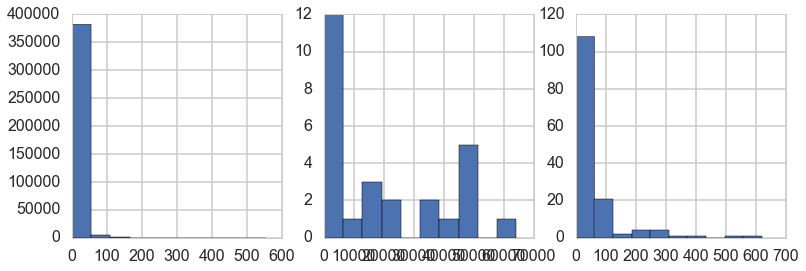

In [17]:
fig = plt.figure()
fig.add_subplot(231)
_=plt.hist(AdRp_noMtDNA["damID-Dam_Fr188_C1"], bins=10)
fig.add_subplot(232)
_=plt.hist(AdRp[Locations[0]=="mitochondrion_genome"]["damID-Dam_Fr188_C1"].values, bins=10)
fig.add_subplot(233)
_=plt.hist(AdRp[Locations[0]=="rDNA"]["damID-Dam_Fr188_C1"].values, bins=10)


# Correlate dataframes

Here we correlate the dataframes.  They aren't very correlated.  

[As a first pass, we hadn't removed mitochondrial DNA information, so the datasets looked much more correlated]

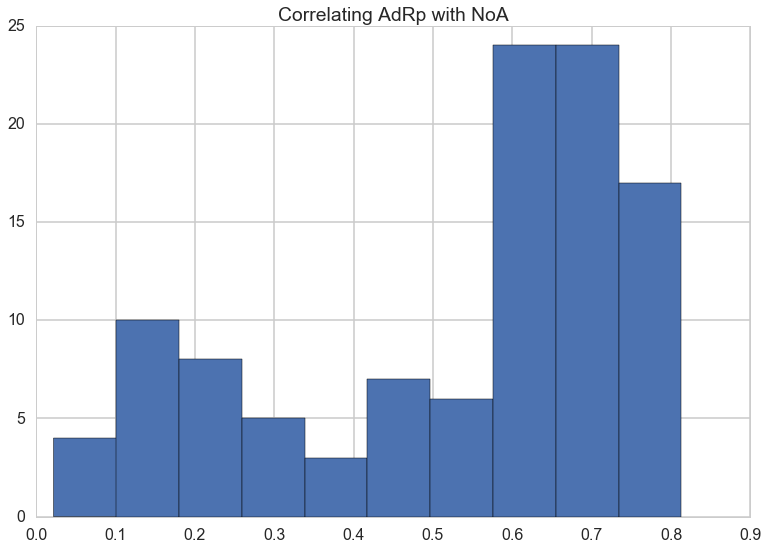

In [18]:
AdRp_NoA_correls = AdRp_noMtDNA.corrwith(NoA_noMtDNA)
_=plt.hist(AdRp_NoA_correls)
_=plt.title("Correlating AdRp with NoA")


In [19]:
#We print out the correlations
AdRp_NoA_correls.head()

damID-Dam_Fr188_C1    0.603771
damID-Dam_Fr188_C2    0.590069
damID-Dam_Fr188_C3    0.279264
damID-Dam_Fr188_C4    0.620678
damID-Dam_Fr188_T3    0.286579
dtype: float64

We plot scatter the first column (damID-Dam_Fr188_C1) of both datasets (AdRp and NoA) to get a clearer picture.  This had a correlation of 0.607154.

[[ 1.          0.60377138]
 [ 0.60377138  1.        ]]


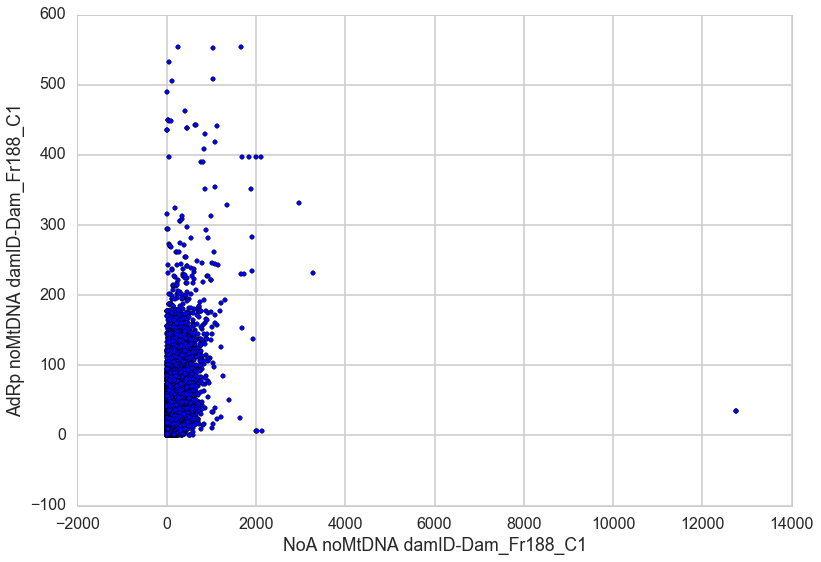

In [20]:
print np.corrcoef(NoA_noMtDNA["damID-Dam_Fr188_C1"],AdRp_noMtDNA["damID-Dam_Fr188_C1"])
plt.xlabel("NoA noMtDNA damID-Dam_Fr188_C1")
plt.ylabel("AdRp noMtDNA damID-Dam_Fr188_C1")

plt.scatter(NoA_noMtDNA["damID-Dam_Fr188_C1"], AdRp_noMtDNA["damID-Dam_Fr188_C1"])

It's a little difficult to see because of the outlier point.  We zoom in.  I'm actually surprised this has a correlation of .6. Looks pretty noisy to me

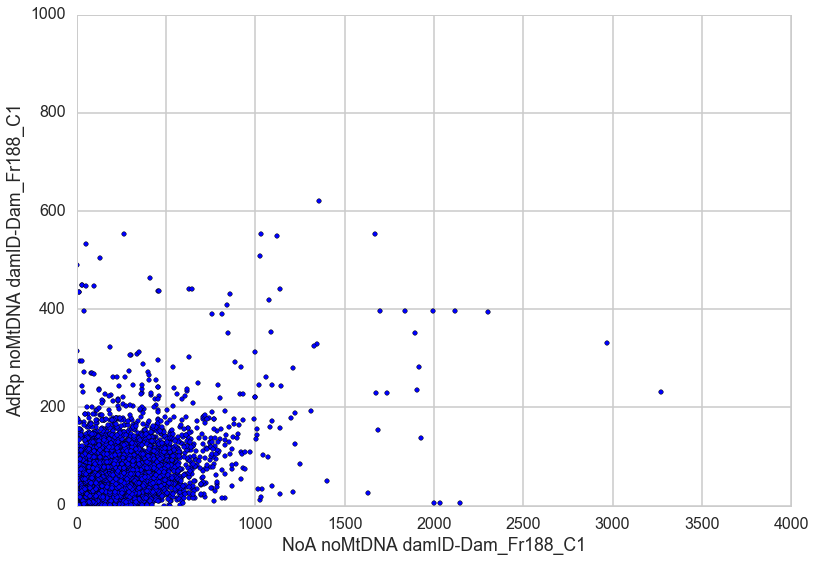

In [14]:
plt.scatter(NoA_noMtDNA["damID-Dam_Fr188_C1"], AdRp_noMtDNA["damID-Dam_Fr188_C1"])
plt.xlim([0,4000])
plt.ylim([0,1000])
plt.xlabel("NoA noMtDNA damID-Dam_Fr188_C1")
plt.ylabel("AdRp noMtDNA damID-Dam_Fr188_C1")

What was the outlier point?

In [15]:
NoA_noMtDNA[NoA_noMtDNA["damID-Dam_Fr188_C1"]>5000]

,damID-Dam_Fr188_C1,damID-Dam_Fr188_C2,damID-Dam_Fr188_C3,damID-Dam_Fr188_C4,damID-Dam_Fr188_T3,damID-Dam_Fr188_T4,damID-Dam_Zi257_C1,damID-Dam_Zi257_C2,damID-Dam_Zi257_C3,damID-Dam_Zi257_W,damID-Dam_Zi275_T1,damID-Lam_Fr188_C1,damID-Lam_Fr188_C2,damID-Lam_Fr188_C3,damID-Lam_Fr188_C,damID-Lam_Fr188_T2,damID-Lam_Fr188_T3,damID-Lam_Zi257_C1,damID-Lam_Zi257_C2,damID-Lam_Zi257_C3,damID-Lam_Zi257_T1,damID-Lam_Zi257_T2,damID-Lam_Zi257_T3,damID2-D1_Fr188_C1,damID2-D1_Fr188_C2,damID2-D1_Fr188_C3,damID2-D1_Fr188_T2,damID2-D1_Fr188_T3,damID2-D1_Fr89_C1,damID2-D1_Fr89_C2,damID2-D1_Fr89_C3,damID2-D1_Fr89_T2,damID2-D1_Fr89_T3,damID2-D1_Zi238_C1,damID2-D1_Zi238_C2,damID2-D1_Zi238_C3,damID2-D1_Zi238_T2,damID2-D1_Zi238_T3,damID2-D1_Zi257_C1,damID2-D1_Zi257_C2,damID2-D1_Zi257_C3,damID2-D1_Zi257_T1,damID2-D1_Zi257_T2,damID2-D1_Zi257_T3,damID2-Dam_Fr188_w,damID2-Dam_Fr89_C1,damID2-Dam_Fr89_C3,damID2-Dam_Fr89_T1,damID2-Dam_Fr89_T2,damID2-Dam_Fr89_T3,...,damID2-Lam_Zi238_C3,damID2-Lam_Zi257_C4,damID3-D1_Fr188_T,damID3-D1_Fr188_w1,damID3-D1_Fr188_w2,damID3-D1_Fr188_w3,damID3-D1_Fr89_w1,damID3-D1_Fr89_w2,damID3-D1_Fr89_w3,damID3-D1_Zi238_T,damID3-D1_Zi238_w1,damID3-D1_Zi238_w2,damID3-D1_Zi238_w3,damID3-D1_Zi257_T,damID3-D1_Zi257_w1,damID3-D1_Zi257_w2,damID3-D1_Zi257_w3,damID3-Dam_Fr188_T2,damID3-Dam_Fr188_w1,damID3-Dam_Fr188_w2,damID3-Dam_Fr188_w3,damID3-Dam_Fr89_w1,damID3-Dam_Fr89_w2,damID3-Dam_Fr89_w3,damID3-Dam_Zi238_T1,damID3-Dam_Zi238_T2,damID3-Dam_Zi238_w1,damID3-Dam_Zi238_w2,damID3-Dam_Zi238_w3,damID3-Dam_Zi257_T1,damID3-Dam_Zi257_T2,damID3-Dam_Zi257_w1,damID3-Dam_Zi257_w2,damID3-Dam_Zi257_w3,damID3-Lam_Fr188_T1,damID3-Lam_Fr188_T4,damID3-Lam_Fr188_w1,damID3-Lam_Fr188_w2,damID3-Lam_Fr188_w3,damID3-Lam_Fr89_T1,damID3-Lam_Fr89_T2,damID3-Lam_Fr89_w1,damID3-Lam_Fr89_w2,damID3-Lam_Fr89_w3,damID3-Lam_Zi238_w1,damID3-Lam_Zi238_w2,damID3-Lam_Zi238_w3,damID3-Lam_Zi257_w1,damID3-Lam_Zi257_w2,damID3-Lam_Zi257_w3
220136,12746,8667,38708,4302,32059,56732,115,345,3370,7934,70770,33,36,2148,784,122,53,4827,3454,2433,8516,4030,9672,89,1427,16220,157,2724,74,21202,16271,78,184,12978,12543,17925,79,187,8273,17247,13679,8662,262,630,258,17423,47816,11174,21256,32627,...,4375,2966,573,793,377,141,530,1281,118,1584,239,66,136,1633,958,463,166,1023,415,674,511,103,558,622,2027,1766,890,915,849,1731,1835,226,401,93,952,556,95,80,105,1220,1061,104,106,168,191,76,145,138,191,131
220137,12747,8668,38711,4303,32061,56733,116,346,3372,7935,70770,33,38,2150,798,122,53,4828,3456,2434,8516,4033,9672,89,1427,16220,157,2724,74,21202,16271,78,184,12978,12543,17925,79,187,8274,17248,13679,8662,262,630,258,17423,47817,11174,21256,32627,...,4375,2966,573,793,377,142,530,1281,118,1584,239,65,136,1633,958,464,165,1023,415,674,511,103,558,622,2027,1766,890,915,849,1731,1835,226,401,93,952,556,96,80,105,1220,1061,104,106,168,191,76,145,138,191,131


In [16]:
print Locations[0][220136]
print Locations[0][220137]

3R
3R


In [10]:
#Merged = AdRp_noMtDNA
#Merged=AdRp_for_DeSeq

# Add values in dataframes that are correlated by more than 70%

Unfortunately, we're down to only 23 columns...

In [17]:
# Take only entries where correlation greater than .70
New_NoA= NoA_noMtDNA[AdRp_NoA_correls[AdRp_NoA_correls>.70].index]
New_AdRp= AdRp_noMtDNA[AdRp_NoA_correls[AdRp_NoA_correls>.70].index]

In [18]:
print New_NoA.shape
New_NoA.shape ==New_AdRp.shape

(388607, 23)


True

Merge NoA and AdRp datasets

In [19]:
Merged = New_NoA.add(New_AdRp)
Merged.to_csv("Merged")
Merged.head()

,damID-Lam_Fr188_C,damID-Lam_Fr188_T2,damID-Lam_Zi257_C3,damID3-D1_Fr188_T,damID3-D1_Fr188_w1,damID3-D1_Fr188_w2,damID3-D1_Fr89_w1,damID3-D1_Fr89_w2,damID3-D1_Zi238_T,damID3-D1_Zi238_w1,damID3-D1_Zi257_T,damID3-D1_Zi257_w1,damID3-Dam_Fr188_T2,damID3-Dam_Zi238_T1,damID3-Dam_Zi238_T2,damID3-Dam_Zi257_T1,damID3-Dam_Zi257_T2,damID3-Lam_Fr188_T1,damID3-Lam_Fr188_T4,damID3-Lam_Fr89_T1,damID3-Lam_Fr89_T2,damID3-Lam_Fr89_w3,damID3-Lam_Zi238_w1
0,2,3,0,0,1,0,1,2,1,1,1,0,2,0,1,0,0,0,0,0,1,2,1
1,1,3,0,0,1,0,1,1,0,1,1,0,2,0,1,0,0,0,0,0,1,1,0
2,1,3,0,0,1,0,2,1,0,1,1,0,2,0,1,0,0,0,0,0,1,2,0
3,1,4,1,1,3,1,2,2,0,2,1,2,2,0,0,0,0,2,2,1,1,3,2
4,3,4,2,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,2,0


## Giving up on merging dataframes

Because there is such little overlap, we might want to just use one of the datasets.  Here we plot a histogram of the sum of the counts 

157836 15604530 101 NoA: Min, max, num columns with counts greater than 500000
114589 5954283 99 AdRp: Min, max,  num columns with counts greater than 500000


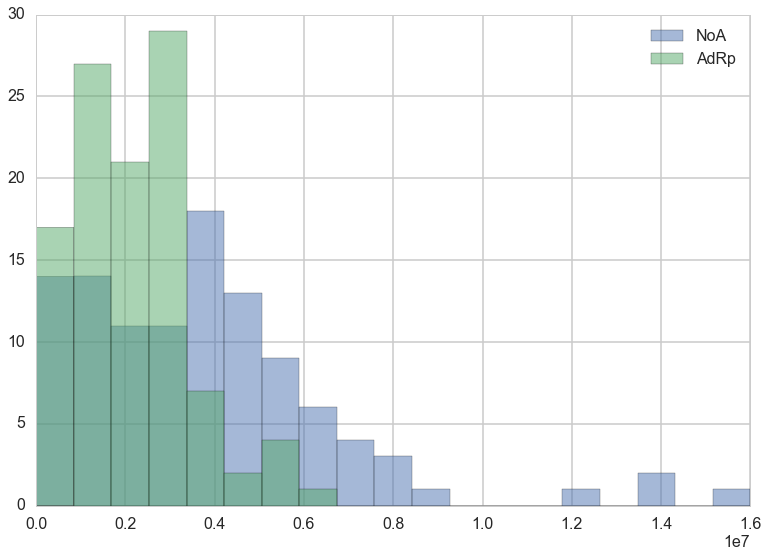

In [21]:
plt.figure()
bins = np.linspace(start=0, stop=16000000, num=20)
_=plt.hist(NoA_noMtDNA.sum(axis=0), bins, label="NoA", alpha=.5)
_=plt.hist(AdRp_noMtDNA.sum(axis=0), bins, label="AdRp", alpha=.5)
plt.legend()

print min(NoA_noMtDNA.sum(axis=0)),max(NoA_noMtDNA.sum(axis=0)) , sum(NoA_noMtDNA.sum(axis=0)>500000),"NoA: Min, max, num columns with counts greater than 500000"
print min(AdRp_noMtDNA.sum(axis=0)),max(AdRp_noMtDNA.sum(axis=0)),  sum(AdRp_noMtDNA.sum(axis=0)>500000), "AdRp: Min, max,  num columns with counts greater than 500000"


We are going to use the AdRp dataset because: "AdRp ones are the ones that have the adaptor sequence at the beginning. That means that are essentially guaranteed to come from methylated sites targeted by the Dam-fusion protein (i.e., what we want). The NoA ones don't have adaptor sequence; we expect some fraction of the actual reads to be missing adaptor sequence since the fragments are long enough that the stuff in the middle (far from the adaptors) can still get sequenced, but they could also arise from various issues."

The AdRp dataset we are going to use contains no mitochondrion genome information, and no columns with count sums less than 500000.

In [22]:
AdRp_for_DeSeq= AdRp_noMtDNA.ix[:,AdRp_noMtDNA.sum(axis=0)>500000]
print AdRp_for_DeSeq.shape
AdRp_for_DeSeq.to_csv("AdRp_noMtDNA")

(388464, 99)


Creating file_names file

In [23]:
def split_names(row):
    labels=["RunProtein", "CountryLine", "TissueRep", "dataset", "notSure1", "notSure2"]
    d = {lab:ele for lab,ele in zip(labels, row.split("_"))}
    return d

def split_TissueRep(TissueRep):
    return {label:ele for label, ele in zip(["Tissue", "Rep"], TissueRep)}

def split_CountryLine(CL): 
    return {label:ele for label, ele in zip(["Country", "Line"], [CL[:2], CL[2:]])}

def separate_protein(RunProtein):
    return {label:ele for label, ele in zip(["NotSureProtein", "protein"], RunProtein.split("-"))}

file_names = AdRp_for_DeSeq.columns

ind = [row.split("_cut")[0] for row in file_names]

file_names=pd.DataFrame([split_names(row) for row in file_names])

file_names=pd.concat([file_names, pd.DataFrame([split_TissueRep(row) for row in file_names["TissueRep"]])], axis=1)
del file_names["TissueRep"]

file_names=pd.concat([file_names, pd.DataFrame([split_CountryLine(row) for row in file_names["CountryLine"]])], axis=1)
del file_names["CountryLine"]

file_names=pd.concat([file_names, pd.DataFrame([separate_protein(row) for row in file_names["RunProtein"]])], axis=1)
del file_names["RunProtein"]

file_names.index=ind

file_names.to_csv("file_names")

file_names

,Rep,Tissue,Country,Line,NotSureProtein,protein
damID-Dam_Fr188_C1,1,C,Fr,188,damID,Dam
damID-Dam_Fr188_C2,2,C,Fr,188,damID,Dam
damID-Dam_Fr188_C3,3,C,Fr,188,damID,Dam
damID-Dam_Fr188_C4,4,C,Fr,188,damID,Dam
damID-Dam_Fr188_T3,3,T,Fr,188,damID,Dam
damID-Dam_Fr188_T4,4,T,Fr,188,damID,Dam
damID-Dam_Zi257_C1,1,C,Zi,257,damID,Dam
damID-Dam_Zi257_C2,2,C,Zi,257,damID,Dam
damID-Dam_Zi257_C3,3,C,Zi,257,damID,Dam
damID-Dam_Zi257_W,NaN,W,Zi,257,damID,Dam


# Keep only columns with combined counts greater than 500000 (in Merged)

Actually there was nothing to do here because the minimum column counts was 2703509.

In [11]:
min(Merged.sum(axis=0))

533388

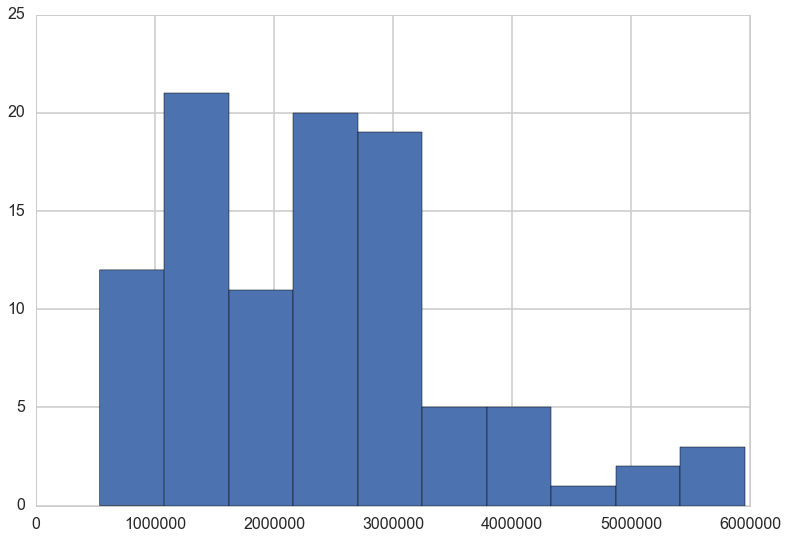

In [12]:
_=plt.hist(Merged.sum(axis=0))

# Making PCAs of each protein/tissue combination

First let's turn column names into a dataframe, so that we can easily separate out tissue, protein, country, line, etc

In [13]:
def split_names(row):
    labels=["RunProtein", "CountryLine", "TissueRep", "dataset", "notSure1", "notSure2"]
    d = {lab:ele for lab,ele in zip(labels, row.split("_"))}
    return d

def split_TissueRep(TissueRep):
    return {label:ele for label, ele in zip(["Tissue", "Rep"], TissueRep)}

def split_CountryLine(CL): 
    return {label:ele for label, ele in zip(["Country", "Line"], [CL[:2], CL[2:]])}

def separate_protein(RunProtein):
    return {label:ele for label, ele in zip(["NotSureProtein", "protein"], RunProtein.split("-"))}

file_names = Merged.columns

ind = [row.split("_cut")[0] for row in file_names]

file_names=pd.DataFrame([split_names(row) for row in file_names])

file_names=pd.concat([file_names, pd.DataFrame([split_TissueRep(row) for row in file_names["TissueRep"]])], axis=1)
del file_names["TissueRep"]

file_names=pd.concat([file_names, pd.DataFrame([split_CountryLine(row) for row in file_names["CountryLine"]])], axis=1)
del file_names["CountryLine"]

file_names=pd.concat([file_names, pd.DataFrame([separate_protein(row) for row in file_names["RunProtein"]])], axis=1)
del file_names["RunProtein"]

file_names.index=ind

file_names

,Rep,Tissue,Country,Line,NotSureProtein,protein
damID-Dam_Fr188_C1,1,C,Fr,188,damID,Dam
damID-Dam_Fr188_C2,2,C,Fr,188,damID,Dam
damID-Dam_Fr188_C3,3,C,Fr,188,damID,Dam
damID-Dam_Fr188_C4,4,C,Fr,188,damID,Dam
damID-Dam_Fr188_T3,3,T,Fr,188,damID,Dam
damID-Dam_Fr188_T4,4,T,Fr,188,damID,Dam
damID-Dam_Zi257_C1,1,C,Zi,257,damID,Dam
damID-Dam_Zi257_C2,2,C,Zi,257,damID,Dam
damID-Dam_Zi257_C3,3,C,Zi,257,damID,Dam
damID-Dam_Zi257_W,NaN,W,Zi,257,damID,Dam


In [14]:
file_names.to_csv("file_names")

Next, let's make protein/tissue masks

In [15]:
#Protein masks
DamMask = [file_names.loc[name].protein=="Dam" for name in Merged.columns]
LamMask = [file_names.loc[name].protein=="Lam" for name in Merged.columns]
D1Mask = [file_names.loc[name].protein=="D1" for name in Merged.columns]

#Tissue masks
TMask = [file_names.loc[name].Tissue=="T" for name in Merged.columns]
CMask = [file_names.loc[name].Tissue=="C" for name in Merged.columns]
WMask = [(file_names.loc[name].Tissue=="W" or file_names.loc[name].Tissue=="w") for name in Merged.columns]


In [16]:
DamTMask = [a and b for a, b in zip(DamMask, TMask)]
DamCMask = [a and b for a, b in zip(DamMask, CMask)]
DamWMask = [a and b for a, b in zip(DamMask, WMask)]

LamTMask = [a and b for a, b in zip(LamMask, TMask)]
LamCMask = [a and b for a, b in zip(LamMask, CMask)]
LamWMask = [a and b for a, b in zip(LamMask, WMask)]

D1TMask = [a and b for a, b in zip(D1Mask, TMask)]
D1CMask = [a and b for a, b in zip(D1Mask, CMask)]
D1WMask = [a and b for a, b in zip(D1Mask, WMask)]

Let's normalize the Merged dataset by column counts

In [17]:
MergedNormalized=Merged.div(Merged.sum(axis=0), axis=1)
MergedNormalized.head()

,damID-Dam_Fr188_C1,damID-Dam_Fr188_C2,damID-Dam_Fr188_C3,damID-Dam_Fr188_C4,damID-Dam_Fr188_T3,damID-Dam_Fr188_T4,damID-Dam_Zi257_C1,damID-Dam_Zi257_C2,damID-Dam_Zi257_C3,damID-Dam_Zi257_W,damID-Dam_Zi275_T1,damID-Lam_Fr188_C1,damID-Lam_Fr188_C2,damID-Lam_Fr188_C3,damID-Lam_Fr188_C,damID-Lam_Fr188_T2,damID-Lam_Fr188_T3,damID-Lam_Zi257_C1,damID-Lam_Zi257_C2,damID-Lam_Zi257_C3,damID-Lam_Zi257_T1,damID-Lam_Zi257_T2,damID-Lam_Zi257_T3,damID2-D1_Fr188_C3,damID2-D1_Fr188_T3,damID2-D1_Fr89_C2,damID2-D1_Fr89_C3,damID2-D1_Fr89_T3,damID2-D1_Zi238_C1,damID2-D1_Zi238_C3,damID2-D1_Zi238_T3,damID2-D1_Zi257_C1,damID2-D1_Zi257_C2,damID2-D1_Zi257_C3,damID2-D1_Zi257_T2,damID2-D1_Zi257_T3,damID2-Dam_Fr188_w,damID2-Dam_Fr89_C1,damID2-Dam_Fr89_C3,damID2-Dam_Fr89_T1,damID2-Dam_Fr89_T2,damID2-Dam_Zi238_C1,damID2-Dam_Zi238_C2,damID2-Dam_Zi238_C3,damID2-Dam_Zi257_w,damID2-Lam_Fr89_C1,damID2-Lam_Fr89_C2,damID2-Lam_Zi238_C1,damID2-Lam_Zi238_C2,damID2-Lam_Zi238_C3,damID2-Lam_Zi257_C4,damID3-D1_Fr188_T,damID3-D1_Fr188_w1,damID3-D1_Fr188_w2,damID3-D1_Fr188_w3,damID3-D1_Fr89_w1,damID3-D1_Fr89_w2,damID3-D1_Fr89_w3,damID3-D1_Zi238_T,damID3-D1_Zi238_w1,damID3-D1_Zi238_w2,damID3-D1_Zi238_w3,damID3-D1_Zi257_T,damID3-D1_Zi257_w1,damID3-D1_Zi257_w2,damID3-D1_Zi257_w3,damID3-Dam_Fr188_T2,damID3-Dam_Fr188_w1,damID3-Dam_Fr188_w2,damID3-Dam_Fr188_w3,damID3-Dam_Fr89_w1,damID3-Dam_Fr89_w2,damID3-Dam_Fr89_w3,damID3-Dam_Zi238_T1,damID3-Dam_Zi238_T2,damID3-Dam_Zi238_w1,damID3-Dam_Zi238_w2,damID3-Dam_Zi238_w3,damID3-Dam_Zi257_T1,damID3-Dam_Zi257_T2,damID3-Dam_Zi257_w1,damID3-Dam_Zi257_w2,damID3-Dam_Zi257_w3,damID3-Lam_Fr188_T1,damID3-Lam_Fr188_T4,damID3-Lam_Fr188_w1,damID3-Lam_Fr188_w2,damID3-Lam_Fr188_w3,damID3-Lam_Fr89_T1,damID3-Lam_Fr89_T2,damID3-Lam_Fr89_w1,damID3-Lam_Fr89_w2,damID3-Lam_Fr89_w3,damID3-Lam_Zi238_w1,damID3-Lam_Zi238_w2,damID3-Lam_Zi238_w3,damID3-Lam_Zi257_w1,damID3-Lam_Zi257_w2,damID3-Lam_Zi257_w3
0,9.969672e-07,3.879980e-07,0.000000e+00,0.000000e+00,1.168052e-06,1.564532e-06,7.525825e-07,9.118426e-07,0.000000e+00,0.000000,6.642638e-07,1.102980e-06,9.021379e-07,0.000000e+00,5.205030e-07,6.506069e-07,3.623097e-07,7.109019e-07,1.944601e-07,0,1.011295e-06,4.704514e-07,1.947293e-07,0.000000e+00,0,0.000000e+00,0.000001,0.000000e+00,0,0,0.000002,0,7.197419e-07,0.000000e+00,0.000011,3.813180e-07,1.610641e-06,0.000000e+00,0.000000e+00,0,0,0.000001,0.000000e+00,0.000000,1.466615e-06,0.000000,4.163676e-07,0.000000e+00,8.427603e-07,5.242711e-07,0.000001,0,5.579271e-07,0.000000e+00,0,3.816919e-07,7.128016e-07,3.608044e-07,0.000001,0.000000e+00,0,4.624932e-07,0.000001,0.000000e+00,5.247377e-07,3.136894e-07,3.457405e-07,2.816871e-07,0.000000e+00,8.632794e-07,0.000000e+00,0.000001,0.000000e+00,0,5.872153e-07,0.000000e+00,0,0,0.000000e+00,0,0,8.597702e-07,0,0,0,4.028684e-07,0,0,0,3.722227e-07,0.000000e+00,2.587503e-07,6.631269e-07,3.318825e-07,0.000000e+00,0.000000e+00,0.000000e+00,4.027584e-07,0.000000e+00
1,9.969672e-07,0.000000e+00,0.000000e+00,0.000000e+00,7.787016e-07,1.564532e-06,7.525825e-07,4.559213e-07,0.000000e+00,0.000000,0.000000e+00,7.353201e-07,9.021379e-07,0.000000e+00,2.602515e-07,6.506069e-07,3.623097e-07,5.331765e-07,1.944601e-07,0,1.011295e-06,4.704514e-07,1.947293e-07,0.000000e+00,0,0.000000e+00,0.000000,0.000000e+00,0,0,0.000000,0,7.197419e-07,0.000000e+00,0.000011,3.813180e-07,1.073760e-06,6.329066e-07,0.000000e+00,0,0,0.000001,0.000000e+00,0.000000,1.466615e-06,0.000000,4.163676e-07,0.000000e+00,8.427603e-07,5.242711e-07,0.000001,0,5.579271e-07,0.000000e+00,0,3.816919e-07,7.128016e-07,0.000000e+00,0.000000,0.000000e+00,0,4.624932e-07,0.000001,0.000000e+00,0.000000e+00,0.000000e+00,3.457405e-07,2.816871e-07,0.000000e+00,1.294919e-06,0.000000e+00,0.000001,4.836801e-07,0,5.872153e-07,0.000000e+00,0,0,0.000000e+00,0,0,8.597702e-07,0,0,0,4.028684e-07,0,0,0,3.722227e-07,0.000000e+00,0.000000e+00,3.315634e-07,0.000000e+00,2.815405e-07,0.000000e+00,2.963143e-07,0.000000e+00,0.000000e+00
2,9.969672e-07,0.000000e+00,0.000000e+00,0.000000e+00,7.787016e-07,1.

In [18]:
#here you can choose to input the normalized or not normalized merged dataset

def create_subdfs(Merged):

    LamT=Merged.ix[:,LamTMask]
    DamT=Merged.ix[:,DamTMask]
    D1T=Merged.ix[:,D1TMask]

    LamC=Merged.ix[:,LamCMask]
    DamC=Merged.ix[:,DamCMask]
    D1C=Merged.ix[:,D1CMask]

    LamW=Merged.ix[:,LamWMask]
    DamW=Merged.ix[:,DamWMask]
    D1W=Merged.ix[:,D1WMask]
    
    return LamT, DamT, D1T, LamC, DamC, D1C, LamW, DamW, D1W

LamT, DamT, D1T, LamC, DamC, D1C, LamW, DamW, D1W = create_subdfs(MergedNormalized)

Now we run PCA for each tissue/protein combo.

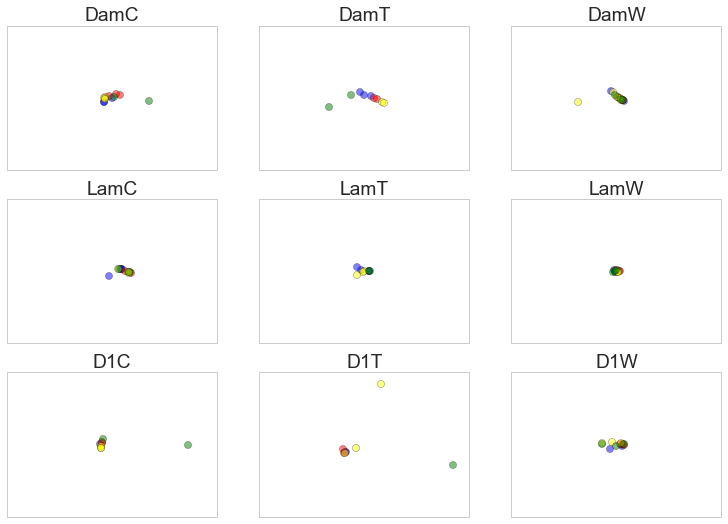

In [20]:
def plot_PCA(data, subplot_spec, title):
    
    pca = PCA(n_components=10)
    X = pca.fit_transform(data.transpose())
    #print pca.explained_variance_ratio_.sum(), "percentage var explained"
    #print pca.explained_variance_ratio_*100, "explained by first PCs"
    
    df=pd.DataFrame()
    for i in range(pca.explained_variance_ratio_.shape[0]):
        df["pc%i" % (i+1)] = X[:,i]

    colors = ["blue", "red", "yellow", 'green']
    labels= ["188","238","257", "89"]
    
    ax1 = fig.add_subplot(subplot_spec, xticklabels=[], yticklabels=[])
    
    for label, color in zip(labels, colors):
        mask = [file_names.loc[name].Line==label for name in data.columns]
        _=ax1.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label, alpha=.5, s =50)
    ax1.set_title(title)
    ax1.grid(b=False)
    #ax1.axis("off")
    #plt.legend()
    #plt.grid(False)
    #plt.show()

fig = plt.figure()

plot_PCA(DamC, 331, "DamC")
plot_PCA(DamT, 332, "DamT")
plot_PCA(DamW, 333, "DamW")
plot_PCA(LamC, 334, "LamC")
plot_PCA(LamT, 335, "LamT")
plot_PCA(LamW, 336, "LamW")
plot_PCA(D1C, 337, "D1C")
plot_PCA(D1T, 338, "D1T")
plot_PCA(D1W, 339, "D1W")



Blue and green are Fr strains, yellow and red are Zi strains

# Normalizing each data set value by mean(Dam-only) value

The final step would be to take mean(D1) / mean(Dam-only) and mean(Lam) / mean(Dam-only) for each line/tissue combination and look at how those values cluster. This should be a very crude way to account for background noise. Note that you'll need to normalize by counts first before averaging across replicates.

In [21]:
CMean=DamC.mean(axis=1)
TMean=DamT.mean(axis=1)
WMean=DamW.mean(axis=1)

In [22]:
LamCNorm = LamC.div(CMean, axis='index')
LamTNorm = LamT.div(TMean, axis='index')
LamWNorm = LamW.div(WMean, axis='index')

D1CNorm = D1C.div(CMean, axis='index')
D1TNorm = D1T.div(TMean, axis='index')
D1WNorm = D1W.div(WMean, axis='index')

DamCNorm = DamC.div(CMean, axis='index')

Drop any rows where there are inf values

In [23]:
LamCNorm=LamCNorm.replace([np.inf, -np.inf], np.nan).dropna()
LamTNorm=LamTNorm.replace([np.inf, -np.inf], np.nan).dropna()
LamWNorm=LamWNorm.replace([np.inf, -np.inf], np.nan).dropna()

D1CNorm=D1CNorm.replace([np.inf, -np.inf], np.nan).dropna()
D1TNorm=D1TNorm.replace([np.inf, -np.inf], np.nan).dropna()
D1WNorm=D1WNorm.replace([np.inf, -np.inf], np.nan).dropna()

DamCNorm=DamCNorm.replace([np.inf, -np.inf], np.nan).dropna()

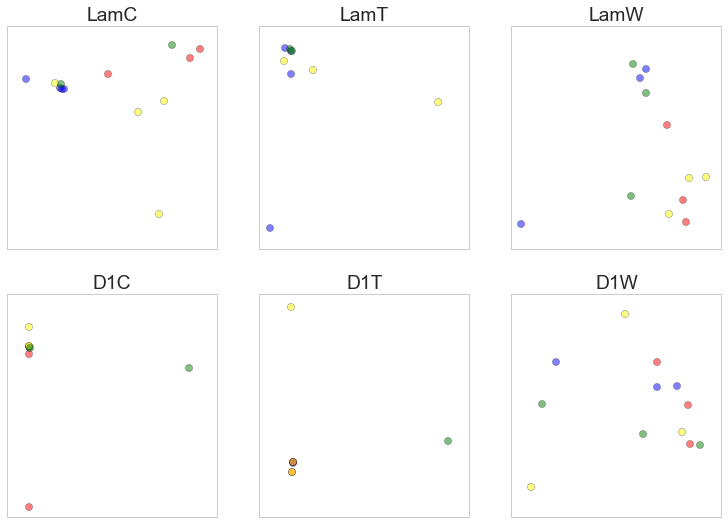

In [24]:
fig = plt.figure()

plot_PCA(LamCNorm, 231, "LamC")
plot_PCA(LamTNorm, 232, "LamT")
plot_PCA(LamWNorm, 233, "LamW")
plot_PCA(D1CNorm, 234, "D1C")
plot_PCA(D1TNorm, 235, "D1T")
plot_PCA(D1WNorm, 236, "D1W")

# Ignore

First we need to get averages for each line/tissue combo in the Dam dataset

In [141]:
Mask188C = [file_names.loc[name].Line=="188" for name in DamC.columns]
Mask238C = [file_names.loc[name].Line=="238" for name in DamC.columns]
Mask257C = [file_names.loc[name].Line=="257" for name in DamC.columns]
Mask89C = [file_names.loc[name].Line=="89" for name in DamC.columns]

Mask188T = [file_names.loc[name].Line=="188" for name in DamT.columns]
Mask238T = [file_names.loc[name].Line=="238" for name in DamT.columns]
Mask257T = [file_names.loc[name].Line=="257" for name in DamT.columns]
Mask89T = [file_names.loc[name].Line=="89" for name in DamT.columns]

Mask188W = [file_names.loc[name].Line=="188" for name in DamW.columns]
Mask238W = [file_names.loc[name].Line=="238" for name in DamW.columns]
Mask257W = [file_names.loc[name].Line=="257" for name in DamW.columns]
Mask89W = [file_names.loc[name].Line=="89" for name in DamW.columns]

In [147]:
C188=DamC.iloc[:,Mask188C].mean(axis=1)
C89=DamC.iloc[:,Mask89C].mean(axis=1)
C238=DamC.iloc[:,Mask238C].mean(axis=1)
C257=DamC.iloc[:,Mask257C].mean(axis=1)

T188=DamT.iloc[:,Mask188T].mean(axis=1)
T89=DamT.iloc[:,Mask89T].mean(axis=1)
T238=DamT.iloc[:,Mask238T].mean(axis=1)
T257=DamT.iloc[:,Mask257T].mean(axis=1)

T188=DamW.iloc[:,Mask188W].mean(axis=1)
T89=DamW.iloc[:,Mask89W].mean(axis=1)
T238=DamW.iloc[:,Mask238W].mean(axis=1)
T257=DamW.iloc[:,Mask257W].mean(axis=1)